# DOREMUS - DBPEDIA ARTISTS MATCHING

In [614]:
import json
import csv
import sys
from os import listdir
from os.path import isfile, join
import queue
import threading
import urllib.request, urllib.error, urllib.parse
import pandas as pd
import numpy as np

<div class="alert alert-success">
We started obtaining from Doremus the artists informations; we used different queries merging them using Pandas dataframe, obtaining a table. It is composed by rows (one for each artists) and  by columns:
<ol>
  <li><strong>uri_doremus</strong> = for every artist, the associated uri in Doremus</li>
  <li><strong>id_doremus</strong> = the object of the property <strong>*ecrm:P131_is_identified_by*</strong>, for every Doremus’s artist</li>
  <li><strong>name_doremus</strong> = the object of the property foaf:name, for every Doremus’s artist</li>
  <li><strong>associated_compositions</strong> = the list of associated works in Doremus</li>
  <li><strong>born_year</strong> = the born year for every artist, but this information is not present for all artists in Doremus</li>
  <li><strong>death_year</strong> = the death year for every artist, but this information is not present for all artists in
  Doremus</li>
  <li><strong>artist_file</strong> = the name of the file in which will be saved (for every artist) the retrieved Dbpedia instances obtained using the Elastic Search</li>
  
</ol> 

The first lines are rapresented below

</div>

In [655]:
pd.read_csv('Artists_Doremus.csv').head()

,Unnamed: 0,uri_doremus,id_doremus,name_doremus,associated_compositions,born_year,death_year,artist_file
0,0,http://data.doremus.org/artist/bdd0ec9b-5b5b-37e1-9beb-32b5b43dd2bd,"Posse, Wilhelm",Wilhelm Posse,http://data.doremus.org/expression/25909066-5d81-34cf-9716-3067d31f0183,NaN,NaN,bdd0ec9b-5b5b-37e1-9beb-32b5b43dd2bd.json
1,1,http://data.doremus.org/artist/ec86d614-972c-397a-8ac1-cfeb5615b185,"Rousée, Jean",Jean Rousée,http://data.doremus.org/expression/9496039c-f0af-3ef6-a1c7-43ec85b1be49,NaN,NaN,ec86d614-972c-397a-8ac1-cfeb5615b185.json
2,2,http://data.doremus.org/artist/c842920a-581d-3673-a123-edc385c7857c,"Gaudio, Bob (1942)",Bob Gaudio,http://data.doremus.org/expression/f60ea13b-df3d-375b-bdcb-537e802567d3,1942.0,NaN,c842920a-581d-3673-a123-edc385c7857c.json
3,3,http://data.doremus.org/artist/70a82bd5-18b8-3f71-8bca-b8c7905ae274,"Lapointe, Jean (1935)",Jean Lapointe,http://data.doremus.org/expression/98412193-fdd9-3efe-93ad-14f0e8c210ca,1935.0,NaN,70a82bd5-18b8-3f71-8bca-b8c7905ae274.json
4,4,http://data.doremus.org/artist/231cf6c9-7d32-3c0b-bf96-8a2bfadb6efe,"Delabre, Christophe",Christophe Delabre,http://data.doremus.org/expression/03a6ca41-b7f8-379c-8c0c-ce8bb8f88ef3|||http://data.doremus.org/expression/1118388e-d142-367a-b642-770c89639d2f|||http://data.doremus.org/expression/427d78fc-1fab-3ce6-b279-0395a2f6c05a,NaN,NaN,231cf6c9-7d32-3c0b-bf96-8a2bfadb6efe.json


<div class="alert alert-success">
The second step was to retrieve the matched entities by Elastic Search. For every Doremus artist we performed 2 queries:
<ol>
  <li>GET dbpedia201510/_search?q=<strong>*NAME_DOREMUS*</strong></li>
  <li>GET dbpedia201510/_search?q=<strong>*ID_DOREMUS*</strong></li>
</ol>
<br>
The ES returns also a score, associated with every entity; the first time we perfomed the matching, we have considered this; however we have noted that it drives to bad results. So we have preferred to not consider it and to score every returned entity using the method that we'll describe below.
</div>

In [615]:

def getQueryResponse(query,endpointURL='http://dbpedia.org/sparql'):
    escapedQuery = urllib.parse.quote(query)
    requestURL = endpointURL + "?query=" + escapedQuery +"&format=CSV"
    try:
        request = urllib.request.Request(requestURL)
        result = urllib.request.urlopen(request)
        return result
    except:
        raise Exception


<div class="alert alert-success">
The first step is to retrieve useful information associated to every entity returned by the ES. In particular we have considered that in Doremus, for every artist, there are informations about the name, the birth date and the death date. So we want to get the same informations for every ES entity. ES already returns the labels (the artist's names) but doesn't gives informations about the birth and the death. To get these info we'll query DBpedia for each year. For example, considering the year 1998:
<pre>
```
{
values ?birth_year { 1998 }
{?resource dct:subject dbc:1998_births.}
UNION
{?resource dbo:birthDate|dbo:birthYear|dbp:dateOfBirth ?birth.
filter regex (str(xsd:date(?birth)),"^1998")}
}
```
</pre>
Looking at the query, you can note that to get the year information we have consider different properties because the most of the time the birth year is written as object of the property `dct:subject`. Actually it's part of the object, e.g. `dbc:1998_births`. However there are cases in which the year is saved as object of other properties as `dbo:birthDate`,`dbo:birthYear`,`dbp:dateOfBirth`. The same considerations could be done for the death year.
<br>
Performing a query for every year asking about all people borned in this year is faster than the inverse: performing a query for every resource asking about the death and the birth year. In fact we have a lot of entities retrieved by the ES queries; instead we have only about 2000 years from 0 to 2017.
We used the first approach joining the result with the ES entities at the end.
<br>
To be faster, we'll perform a query for every 10 years, using the UNION operator.
You can see below all the implementation about what we've described.
</div>

In [661]:
internal_years_query = '''
{
values ?birth_year { YEAR }
{?resource dct:subject dbc:YEAR_births.}
UNION
{?resource dbo:birthDate|dbo:birthYear|dbp:dateOfBirth ?birth.
filter regex (str(xsd:date(?birth)),"^YYYY")}
}
'''

In [662]:
years_birth_query = '''
select distinct ?resource ?birth_year where{
STR_TO_SUB
}
offset OFFSET
limit 10000
'''
artist_years_birth_df = pd.DataFrame([],columns=['resource','birth_year'])
start = 0

In [ ]:
step = 10
for i in range(start,2018,step):
    if i % 10 == 0:
        print (i)
    n = 10000
    start = i
    offset = 0
    int_queries = 'UNION\n'.join([internal_years_query.replace('YEAR',str(j)).replace('YYYY',str(j).zfill(4)) for j in range(i,i+step)])
    while n == 10000:
        query = years_birth_query.replace('STR_TO_SUB',int_queries).replace('OFFSET',str(offset))
        #print(query)
        res = pd.read_csv(getQueryResponse(query,endpointURL='http://dbpedia.org/sparql'))
        if len(res) > 0:
            artist_years_birth_df=artist_years_birth_df.append(res,ignore_index=True).drop_duplicates()
        if len(res) != 10000:
            n = 0
        offset += 10000

In [724]:
artist_years_birth_df = (artist_years_birth_df
                         .groupby('resource')['birth_year']
                         .apply(tuple)
                         .reset_index(name='birth_year')
                        )
artist_years_birth_df.drop_duplicates().to_pickle('artist_years_birth_df')

In [732]:
artist_years_birth_df = pd.read_pickle('artist_years_birth_df')

In [733]:
artist_years_birth_df.head()

,resource,birth_year
0,http://dbpedia.org/resource/!PAUS3,"(1981, 1986)"
1,http://dbpedia.org/resource/%22Bassy%22_Bob_Brockmann,"(1962,)"
2,http://dbpedia.org/resource/%22Big%22_Donnie_MacLeod,"(1928,)"
3,http://dbpedia.org/resource/%22By%22_Dunham,"(1910,)"
4,http://dbpedia.org/resource/%22Dr._Death%22_Steve_Williams,"(1960,)"


In [649]:
internal_years_query = '''
{
values ?death_year { YEAR }
{?resource dct:subject dbc:YEAR_deaths.}
UNION
{?resource dbo:deathDate|dbo:deathYear|dbp:dateOfDeath ?death.
filter regex (str(xsd:date(?death)),"^YYYY")}
}
'''

In [652]:
years_death_query = '''
select distinct ?resource ?death_year where{
STR_TO_SUB
}
offset OFFSET
limit 10000
'''
artist_years_death_df = pd.DataFrame([],columns=['resource','death_year'])
start = 0 

In [ ]:
step = 10
for i in range(start,2018,step):
    if i % 10 == 0:
        print (i)
    n = 10000
    start = i
    offset = 0
    int_queries = 'UNION\n'.join([internal_years_query.replace('YEAR',str(j)).replace('YYYY',str(j).zfill(4)) for j in range(i,i+step)])
    while n == 10000:
        formatted_year = str(i).zfill(4)
        query = years_death_query.replace('STR_TO_SUB',int_queries).replace('OFFSET',str(offset))
        res = pd.read_csv(getQueryResponse(query,endpointURL='http://dbpedia.org/sparql'))
        if len(res) > 0:
            artist_years_death_df=artist_years_death_df.append(res,ignore_index=True).drop_duplicates()
        if len(res) != 10000:
            n = 0
        offset += 10000

In [734]:
artist_years_death_df = (artist_years_death_df
                         .groupby('resource')['death_year']
                         .apply(tuple)
                         .reset_index(name='death_year')
                        )
artist_years_death_df.drop_duplicates().to_pickle('artist_years_death_df')

In [ ]:
artist_years_death_df = pd.read_pickle('artist_years_death_df')

In [736]:
artist_years_death_df.head()

,resource,death_year
0,http://dbpedia.org/resource/%22Big%22_Donnie_MacLeod,"(2003,)"
1,http://dbpedia.org/resource/%22By%22_Dunham,"(2001,)"
2,http://dbpedia.org/resource/%22Dr._Death%22_Steve_Williams,"(2009,)"
3,http://dbpedia.org/resource/%22King%22_Bennie_Nawahi,"(1985,)"
4,http://dbpedia.org/resource/%22Major%22_John_Buchanan,"(1832,)"


In [921]:
#all_elastic_resources = []
doremus_elastic_search_link = []
with open('Artists_Doremus.csv', 'r') as f:
    reader = csv.reader(f)
    count = 0
    for row in reader:
        if count != 0:
            uri_doremus = row[1]
            id_doremus = row[2]
            name_doremus = row[3]
            born_year = row[5]
            if born_year  == '':
                born_year = np.nan
            else:
                born_year = tuple([int(b) for b in born_year.split('|||')])
            death_year = row[6]
            if death_year  == '':
                death_year = np.nan
            else:
                death_year = tuple([int(d) for d in death_year.split('|||')])
            storage_file = row[7]
            item_array = {}
            with open('all_matched/'+storage_file) as matching_file:
                all_matching = json.load(matching_file)
                name_matching = all_matching[name_doremus]["hits"]["hits"]
                id_matching = all_matching[id_doremus]["hits"]["hits"]
                matchings = name_matching + id_matching
                names_doremus = tuple(set(name_doremus.split('|||')+id_doremus.split('|||')))
                for m in matchings:
                    uri=m['_source']["link"]
                    label=tuple(m['_source']["rdfs_label"])
                    #all_elastic_resources.append(uri)
                    doremus_elastic_search_link.append([uri_doremus,names_doremus,born_year,death_year,uri,label])
                #x = input()
        if count % 1000 == 0:
            print (count)
        count += 1
        
#all_elastic_resources_distinct = list(set(all_elastic_resources))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000


In [922]:
columns=['uri_doremus','names_doremus','born_year_doremus','death_year_doremus','resource','resource_label']
doremus_elastic_search_link_df = pd.DataFrame(doremus_elastic_search_link,columns=columns).drop_duplicates()

In [996]:
doremus_elastic_search_link_birth=(pd.merge(
    doremus_elastic_search_link_df,
    artist_years_birth_df,
    on='resource',
    how='left')
    )
doremus_elastic_search_years=(pd.merge(
    doremus_elastic_search_link_birth,
    artist_years_death_df,
    on='resource',
    how='left')
    )

<div class="alert alert-success">
We need also to check that the entities retrieved by the Elastic Search are composers or musicians or arists or at least people. So it's necessary to get the types of every resources, in particular the ones linked whit the idea of composer.
When we'll perform the final scoring we'll assign higher scores more specific the category is.
<br>
For every resource, we'll perform this query:
<pre>
```
{
 values ?uri_doremus { URI_RESOURCE }
 ?uri_doremus rdf:type $type
 filter (?type=<http://schema.org/Person>||?type=<http://xmlns.com/foaf/0.1/Person>||?type=<http://dbpedia.org/ontology/Person>||?type=<http://dbpedia.org/class/yago/Person100007846>||?type=<http://dbpedia.org/class/yago/Creator109614315>||?type=<http://dbpedia.org/class/yago/Artist109812338>||?type=<http://dbpedia.org/class/yago/Musician110339966>||?type=<http://dbpedia.org/class/yago/Composer109947232>)
}
UNION
{
 values ?type {<http://dbpedia.org/class/yago/Composer109947232>}
 values ?uri_doremus { URI_RESOURCE }
 ?uri_doremus dc:description|dbo:occupation|dct:subject ?t
 filter regex(?t,"composer","i")
}
```
</pre>

Also this time we'll group more queries together using the UNION operator to be faster.

</div>

In [795]:
all_elastic_resources_distinct = list(doremus_elastic_search_years['resource'].drop_duplicates())

int_query = '''{
 values ?uri_doremus { <STR_TO_SUB> }
 ?uri_doremus rdf:type $type
 
}'''

In [848]:
int_query = '''{
{
 values ?resource { <STR_TO_SUB> }
 ?resource rdf:type $type
 filter (?type=<http://schema.org/Person>||?type=<http://xmlns.com/foaf/0.1/Person>||?type=<http://dbpedia.org/ontology/Person>||?type=<http://dbpedia.org/class/yago/Person100007846>||?type=<http://dbpedia.org/class/yago/Creator109614315>||?type=<http://dbpedia.org/class/yago/Artist109812338>||?type=<http://dbpedia.org/class/yago/Musician110339966>||?type=<http://dbpedia.org/class/yago/Composer109947232>)
}
UNION
{
 values ?type {<http://dbpedia.org/class/yago/Composer109947232>}
 values ?resource { <STR_TO_SUB> }
 ?resource dc:description|dbo:occupation|dct:subject ?t
 filter regex(?t,"composer","i")
}
}'''

In [849]:
basic_query = '''
select $resource $type
where {

STR_TO_SUB

}'''

In [852]:
artist_category_df = pd.DataFrame([],columns=['resource','type'])
trace = 0

In [856]:
start = trace
end = len(all_elastic_resources_distinct)
step = 1
for i in range(start,end,step):
    if i % 350 == 0:
        print(i)
    core_query_arr = [int_query.replace('STR_TO_SUB',all_elastic_resources_distinct[j]) for j in range(i,i+step)]
    core_query = '\nUNION\n'.join(core_query_arr)
    query = basic_query.replace('STR_TO_SUB',core_query)
    res = pd.read_csv(getQueryResponse(query,endpointURL='http://dbpedia.org/sparql'))
    artist_category_df=artist_category_df.append(res,ignore_index=True)
    trace += step
    

In [857]:
artist_category_df=artist_category_df.drop_duplicates()
artist_category_df.columns = ['resource','categories']

In [858]:
artist_category_df.to_pickle('artist_category_df')

In [859]:
artist_category_df_grouped = artist_category_df.groupby('resource')['categories'].apply(tuple).reset_index(name="categories")

In [997]:
doremus_dbpedia_link_df=pd.merge(doremus_elastic_search_years,artist_category_df_grouped, on='resource', how='left')

In [1024]:
doremus_dbpedia_link_df.to_pickle('doremus_dbpedia_link_df')

<div class="alert alert-success">
After getting the categories and the years associtated with the entities returned by the ES, we define a method to score the Doremus-Dbpedia artist links. This criteria keeps into account:
<ul>
  <li><strong>The names/labels similarity</strong>: to compute it we used a Python library called "fuzzywuzzy" that uses the Levenshtein Distance to compute the string similarity</li>
  <li><strong>The year matching</strong>: for every pair Doremus artist-Dbpedia artist we check if the born year and the death year is the same. However the year informations are not always present in both Doremus and Dbpedia. So we can have different possibilities:
  <ol>
  <li> If the information is present on both sides and fits we assign an high to the possible Dbpedia artist candidate </li>
  <li> In the case in which the informations are present only on one side we assigned score 0 but we continue to consider the Dbpedia entity as a possible candidate,because we haven't enough information to say the 2 entities are not the same.</li>
  <li>Instead, if the information is present on both sides but it's different we delete the Dbpedia artist from the candidates. Actually we don't eliminate the candidate if the years differ for 1 or 2 years, because we have noted that, especially for the old artists, the dates are not always precise </li>
  <li> If the birth year is present on both sides and fits but the death year is not present on both sides, it could mean that the artist is not already death. To check that we basically look at the birth date and, if it is not too far from the current date, we consider the artist as still alive, and we increase the score also for the death year matching. However this score rise is less significant than when we have explicitly the same death year.  </li>
  </ol>  
  <li><strong>Finally we check the categories of the Dbpedia entity</strong>: if it is a composer we assign a high score, alternately we assign a lower score if it is only an artist, and so on. The score assignment descreases following a gaussian distribution. If the entity is not a person we assign a negative score.</li>
</ul>

</div>

In [970]:
doremus_dbpedia_link_df= pd.read_pickle('doremus_dbpedia_link_df')

In [999]:
doremus_dbpedia_link_np = doremus_dbpedia_link_df.as_matrix()

In [1071]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from scipy import signal

def similar(a, b,w):
    return (w*fuzz.token_sort_ratio(a, b)+(1-w)*fuzz.ratio(a,b))/100
def YearMatching(arr_years1,arr_years2):
    if type(arr_years1)==float or type(arr_years2)==float:
        return 0.0
    else:
        arr_years1_b = ([y+1 for y in list(arr_years1)] + 
                        [y+2 for y in list(arr_years1)] +
                        [y-1 for y in list(arr_years1)] +
                        [y-2 for y in list(arr_years1)]
                       )
        arr_years2_b = ([y+1 for y in list(arr_years1)] + 
                        [y+2 for y in list(arr_years1)] +
                        [y-1 for y in list(arr_years1)] +
                        [y-2 for y in list(arr_years1)]
                       )
        #print(set(list(arr_years2)))
        #x = input()
        if set(list(arr_years1)) & set(list(arr_years2)):
            return 1.0
        elif set(arr_years1_b) & set(arr_years2_b):
            return 0.3
        else:
            return -1.0
def LabelMatching(arr_str1,arr_str2):
    sim = 0.0
    for s1 in arr_str1:
        for s2 in arr_str2:
            sim = max([similar(s1, s2,0.6),sim])
            if sim == 1.0:
                return sim
    return sim

def CategoryMatching(list_categories,weight_categories,categories):
    if not type(categories)==float:
        for i in range(n-1,-1,-1):
            if set(list_categories[i]) & set(categories):
                return weight_categories[i]
    else:
        return -0.8
    
def evaluateSupposition(age):
    if age < 50:
        return 1.0
    else:
        return -(1/100)*age + 3/2
            
            

In [930]:
n = len(list_categories)
weight_categories = signal.gaussian(n*2+1, std=1.3)[1:n+1]

In [931]:
list_categories = ([['http://schema.org/Person',
  'http://xmlns.com/foaf/0.1/Person',
  'http://dbpedia.org/ontology/Person',
  'http://dbpedia.org/class/yago/Person100007846'],
 ['http://dbpedia.org/class/yago/Creator109614315'],
 ['http://dbpedia.org/class/yago/Artist109812338'],
 ['http://dbpedia.org/class/yago/Musician110339966'],
 ['http://dbpedia.org/class/yago/Composer109947232']])

In [932]:
w_label = 0.25
w_birth = 0.25
w_death = 0.25
w_category = 0.25

In [933]:
from datetime import date
current_year = date.today().year

In [1072]:
doremus_dbpedia_score_np= []
for i,link in enumerate(doremus_dbpedia_link_np):
    if i % 1000 == 0:
        print (i)
    doremus_uri = link[0]
    doremus_label = link[1]
    doremus_born = link[2]
    doremus_death = link[3]
    dbpedia_uri = link[4]
    dbpedia_label = link[5]
    dbpedia_born = link[6]
    dbpedia_death = link[7]
    dbpedia_category = link[8]
    score_birth = YearMatching(doremus_born,dbpedia_born)
    if not score_birth < 0.0:
        score_death_partial = YearMatching(doremus_death,dbpedia_death)
        if not score_death_partial < 0.0:
            if score_birth == 1.0:
                age = current_year - dbpedia_born[0]
                if age < 100 and score_death_partial==0.0:
                    score_death = 0.9*evaluateSupposition(age)
                    threshold_label = 0.88
                else:
                    score_death = score_death_partial
                    threshold_label = 0.65
            else:
                score_death = score_death_partial
                threshold_label = 0.65
            score_label = LabelMatching(list(doremus_label),list(dbpedia_label))
            if score_label > threshold_label:
                score_category = CategoryMatching(list_categories,weight_categories,dbpedia_category)
                score = (w_birth*score_birth + w_death*score_death + w_label*score_label + w_category*score_category) 
                new_link = [doremus_uri,dbpedia_uri,score_label,score_birth,score_death,score_category,score]
                doremus_dbpedia_score_np.append(new_link)
    #print(paths_filtered_with_score_np)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [1073]:
doremus_dbpedia_score = pd.DataFrame(np.array(doremus_dbpedia_score_np),columns=['doremus_uri','dbpedia_uri','score_label','score_birth','score_death','score_category','score']).drop_duplicates()

In [1074]:
doremus_dbpedia_artist_final = (doremus_dbpedia_score
                                .sort_values('score', ascending=False)
                                .groupby('doremus_uri', as_index=False)
                                .first()
                                .sort_values('score', ascending=False)
                               )

In [1075]:
doremus_dbpedia_artist_final = (doremus_dbpedia_artist_final
                                .sort_values('score', ascending=False)
                                .groupby('dbpedia_uri', as_index=False)
                                .first()
                                .sort_values('score', ascending=False)
                               )

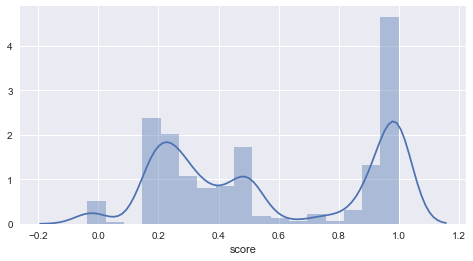

In [1078]:
import seaborn as sns, numpy as np
sns.set(rc={"figure.figsize": (8, 4)}); np.random.seed(0)
x = doremus_dbpedia_artist_final['score'].astype(float)
ax = sns.distplot(x)
sns.plt.show()

In [1045]:
doremus_dbpedia_artist_final = doremus_dbpedia_artist_final.sort_values('score',ascending=False)

In [1079]:
doremus_dbpedia_artist_final.to_pickle("doremus_dbpedia_artist_final")

In [1047]:
doremus_dbpedia_artist_final= pd.read_pickle('doremus_dbpedia_artist_final')

In [1048]:
doremus_dbpedia_filtered=doremus_dbpedia_artist_final[doremus_dbpedia_artist_final['score'].astype(float)>=0.6][['doremus_uri','dbpedia_uri','score']]

In [1080]:
doremus_dbpedia_filtered=doremus_dbpedia_artist_final[['doremus_uri','dbpedia_uri','score']]

In [1081]:
doremus_dbpedia_filtered.columns = ['uri_doremus','uri_dbpedia','rank']

In [1082]:
doremus_dbpedia_filtered.to_csv('doremus_dbpedia_artists.csv',index=False)